# Revolut Fraud Detection

In [ ]:
import re
from tqdm import tqdm
from IPython.display import display
from datetime import datetime, timedelta

# Data mnunging
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Feature Engineering
from multiprocessing import Pool
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Modeling
import xgboost as xgb
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_curve

# Ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Set seed for consistent result
SEED = 123
np.random.seed(SEED)

This is a user level model meaning, our job is to detect whether a given user is a fraudster or not based on their profile information along with the transactional information.



## 1 - Problem Definition

Improvement of fraud detection at Revolut:

* **Predictive Modeling**: Create a model that predicts the probability of a user being fraudulent, utilizing historical user profiles and transaction details.
* **Operational Strategy**: Define how the predictive model will be integrated into operational workflows. This includes determining the appropriate action to take when a user is flagged as potentially fraudulent (`LOCK_USER`, preventing further transactions, or `ALERT_AGENT`, triggering a manual review).

In [ ]:
# Load data
df_users = pd.read_csv('revolut_users.csv')
df_transactions = pd.read_csv('revolut_transactions.csv')

In [ ]:
df_users.head()

,id,has_email,phone_country,terms_version,created_date,country,birth_year,kyc,failed_sign_in_attempts,is_fraud
0,1872820f-e3ac-4c02-bdc7-727897b60043,1,GB||JE||IM||GG,2024-05-23,2023-08-05 07:33:33.341,GB,1971,PASSED,0,0
1,545ff94d-66f8-4bea-b398-84425fb2301e,1,GB||JE||IM||GG,2023-12-31,2023-03-06 10:18:59.427,GB,1982,PASSED,0,0
2,10376f1a-a28a-4885-8daa-c8ca496026bb,1,ES,2024-09-18,2024-05-29 04:41:24.672,ES,1973,PASSED,0,0
3,fd308db7-0753-4377-879f-6ecf2af14e4f,1,FR,2024-05-23,2024-05-30 17:24:23.852,FR,1986,PASSED,0,0
4,755fe256-a34d-4853-b7ca-d9bb991a86d3,1,GB||JE||IM||GG,2024-09-18,2023-08-08 15:03:33.945,GB,1989,PASSED,0,0


In [ ]:
df_transactions.head()

,currency,state,created_date,merchant_category,merchant_country,entry_method,user_id,type,source,id,amount_usd,is_crypto
0,GBP,COMPLETED,2023-12-19 12:46:20.294,cafe,GBR,cont,8f99c254-7cf2-4e35-b7e4-53804d42445d,CARD_PAYMENT,GAIA,b3332e6f-7865-4d6e-b6a5-370bc75568d8,220,False
1,EUR,COMPLETED,2023-12-19 12:38:47.232,bar,AUS,cont,ed773c34-2b83-4f70-a691-6a7aa1cb9f11,CARD_PAYMENT,GAIA,853d9ff8-a007-40ef-91a2-7d81e29a309a,2885,False
2,EUR,COMPLETED,2023-12-19 12:34:39.668,NaN,CZE,cont,eb349cc1-e986-4bf4-bb75-72280a7b8680,CARD_PAYMENT,GAIA,04de8238-7828-4e46-91f1-050a9aa7a9df,1198,False
3,GBP,COMPLETED,2023-12-19 12:45:50.555,supermarket,GBR,cont,dc78fbc4-c936-45d3-a813-e2477ac6d74b,CARD_PAYMENT,GAIA,2b790b9b-c312-4098-a4b3-4830fc8cda53,249,False
4,EUR,COMPLETED,2023-12-19 12:45:32.722,NaN,FRA,cont,32958a5c-2532-42f7-94f9-127f2a812a55,CARD_PAYMENT,GAIA,6469fc3a-e535-41e9-91b9-acb46d1cc65d,1101,False


## 2 - Exploratory Data Analysis

1. Generate tables and/or charts that illustrate insights.
2. Identify potential data quality issues that require addressing.
3. Discover patterns and trends that can guide feature engineering and model selection.

##Overview


In [ ]:
# Create an exploratory dataset
df_eda = df_users.copy()

# Set select fields as datetime data type
df_eda['created_date'] = pd.to_datetime(df_eda['created_date'])


# Let's do an overview
df_eda.describe()

,has_email,created_date,birth_year,failed_sign_in_attempts,is_fraud
count,9944.000000,9944,9944.000000,9944.000000,9944.000000
mean,0.946702,2023-10-17 07:39:49.368646400,1983.553298,0.008045,0.029968
min,0.000000,2022-01-01 12:34:05.122000,1927.000000,0.000000,0.000000
25%,1.000000,2023-06-03 05:25:02.747249920,1978.000000,0.000000,0.000000
50%,1.000000,2024-01-06 16:41:24.968000,1986.000000,0.000000,0.000000
75%,1.000000,2024-04-26 09:59:36.345750016,1992.000000,0.000000,0.000000
max,1.000000,2024-07-29 13:26:13.492000,2000.000000,6.000000,1.000000
std,0.224639,NaN,11.350379,0.129737,0.170507


Generally more users `have email`, when they establish profile with Revolut account versus users who do not.

In terms of `birth years`, users are from the 90's generally speaking.

For `failed sign in attempts`, there might be some underlying patterns in terms of users who have multiple sign-in attempts that have failed maybe they're trying to take over the account.

`Is_Fraud` is main prediction point, we can see about 3% of users in the table are fraudsters.

## EDA

In [ ]:
def df_overview(df=pd.DataFrame) -> pd.DataFrame:
    """
    Provides an overview of the columns in the dataframe

    Args:
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: A DataFrame containing the overview of the columns.
    """

    overview = pd.concat([
        df.dtypes,
        df.isna().mean(),
        df.nunique()
    ], axis=1)
    overview.columns = ['datatype', 'missingness','nunique']

    return overview

def eda_categorical(df=pd.DataFrame, feature=str, target=str, sorted_on='count', ascending=False, filter=10, fill_na=True) -> pd.DataFrame:
    """
    Performs exploratory data analysis (EDA) for categorical features.

    This function calculates the frequency of each category in the 'feature' column
    and the average value of the 'target' column for each category. It then sorts
    the results based on the 'sorted_on' parameter.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the categorical feature column.
        target (str): The name of the target column (usually a numerical or binary column).
        sorted_on (str, optional): The column to sort the results by ('count' or 'target').
                                    Defaults to 'count'.
        ascending (bool, optional): Whether to sort in ascending order. Defaults to False.
        filter (int, optional): The maximum number of rows to return. Defaults to 10.
        fill_na (bool, optional): Whether to fill missing values in the 'feature' column.
                                  Defaults to True.

    Returns:
        pd.DataFrame: A DataFrame containing the frequency of each category and the
                      average target value for each category, sorted according to
                      the specified parameters.
    """

    # Check that sorted_on is 'feature' or 'target'
    if sorted_on not in ['count', 'is_fraud', 'feature']:
        raise ValueError("sorted_on must be 'count', 'is_fraud'")

    sorted_on = feature if sorted_on == 'feature' else sorted_on

    # Fill na is 'MISSING'
    if fill_na == True:
        df[feature] = df[feature].fillna('MISSING')

    # Get the count of is_fraud and not is_fraud by country
    table = pd.concat([
        df[feature].value_counts(),
        df.groupby(feature)[target].mean().round(3)
    ], axis=1)

    return table.sort_values(by=sorted_on, ascending=ascending).head(filter)

def eda_continuous(df=pd.DataFrame, feature=str, target=str, range=(0.1, 1.0, 0.1)) -> pd.DataFrame:
    """
    Performs exploratory data analysis (EDA) for continuous features.

    This function groups the DataFrame by the 'target' column and calculates
    descriptive statistics for the 'feature' column within each group.
    It uses the specified percentiles to provide a more detailed view
    of the distribution of the continuous feature.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature (str): The name of the continuous feature column.
        target (str): The name of the target column (usually a categorical or binary column).
        range (tuple, optional): A tuple specifying the start, stop, and step
                                  for generating percentiles. Defaults to (0.1, 1.0, 0.1).

    Returns:
        pd.DataFrame: A DataFrame containing descriptive statistics for the
                      'feature' column within each group of the 'target' column.
    """

    # Group the DataFrame by the target column and calculate descriptive statistics
    # for the specified feature, using the given percentiles.
    table = (
        df
            .groupby(target)[feature]
            .describe(percentiles=np.arange(0.1, 1.0, 0.1))
    )

    # Return the resulting DataFrame.
    return table

## Users

### Missingness & Datatypes

In [ ]:
# What percentage of the records are missing per each fieldf
df_overview(df=df_eda)

,datatype,missingness,nunique
id,object,0.00000,9944
has_email,int64,0.00000,2
phone_country,object,0.00000,83
terms_version,object,0.15356,7
created_date,datetime64[ns],0.00000,9944
country,object,0.00000,46
birth_year,int64,0.00000,69
kyc,object,0.00000,4
failed_sign_in_attempts,int64,0.00000,5
is_fraud,int64,0.00000,2


Country & phone country features have high cardinality. We cannot just do one-hot encoding, that would cause a high sparsity into our feature set.

### Target Analysis

In [ ]:
# has_email
eda_categorical(df=df_eda, feature='has_email', target='is_fraud')

,count,is_fraud
has_email,,
1,9414,0.032
0,530,0.002


In [ ]:
# Phone Country
eda_categorical(df=df_eda, feature='phone_country', target='is_fraud')

,count,is_fraud
phone_country,,
GB||JE||IM||GG,4302,0.061
FR,1309,0.002
PL,672,0.003
LT,492,0.028
ES,411,0.007
IE,410,0.000
GR,287,0.000
RO,227,0.031
DE,217,0.000


`GB||JE||IM||GG` tag shows that these occurence appeared in about 50% of the entire data of the users table and are highly associated with the fraud around 6% compared to the other ones

In [ ]:
# terms_version
eda_categorical(df=df_eda, feature='terms_version', target='is_fraud', sorted_on='feature', ascending=True)

,count,is_fraud
terms_version,,
2023-01-15,121,0.000
2023-02-01,74,0.108
2023-12-31,232,0.052
2024-01-12,440,0.014
2024-03-18,2048,0.056
2024-05-23,3393,0.027
2024-09-18,2109,0.000
MISSING,1527,0.044


There's some association with the terms that were applied to the account creation and actual fraud rate.

In [ ]:
# User KYC
eda_categorical(df=df_eda, feature='kyc', target='is_fraud')

,count,is_fraud
kyc,,
PASSED,6969,0.037
NONE,2631,0.000
FAILED,270,0.081
PENDING,74,0.216


In [ ]:
# Failed Sign-in Attempt
eda_categorical(df=df_eda, feature='failed_sign_in_attempts', target='is_fraud')

,count,is_fraud
failed_sign_in_attempts,,
0,9895,0.03
1,25,0.04
2,20,0.10
3,3,0.00
6,1,0.00


In [ ]:
# Date
df_eda['created_year'] = df_eda['created_date'].dt.year
df_eda['created_month'] = df_eda['created_date'].dt.month

display(eda_categorical(df=df_eda, feature='created_year', target='is_fraud', sorted_on='feature', ascending=True))
print('')
display(eda_categorical(df=df_eda, feature='created_month', target='is_fraud', sorted_on='feature', ascending=True, filter=12))

,count,is_fraud
created_year,,
2022,1656,0.007
2023,3177,0.036
2024,5111,0.034


,count,is_fraud
created_month,,
1,907,0.024
2,775,0.039
3,1113,0.055
4,941,0.039
5,1143,0.029
6,1222,0.020
7,1186,0.015
8,427,0.035
9,423,0.038


We can see an increase of fraud rate in 2023 & 2024. There is no strong relationship on a per month to month basis, but it fluctuates between 2 to 3%.

In [ ]:
eda_continuous(df=df_eda, feature='birth_year', target='is_fraud')

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraud,,,,,,,,,,,,,,
0,9646.0,1983.438627,11.377163,1927.0,1967.0,1975.0,1980.0,1983.0,1986.0,1989.0,1991.0,1993.0,1995.0,2000.0
1,298.0,1987.265101,9.759405,1936.0,1976.0,1981.0,1986.0,1988.0,1989.0,1991.0,1993.0,1995.0,1997.0,2000.0


## Transaction

In [ ]:
df_eda_t = (
    df_users
        .merge(df_transactions, how='right', left_on='id', right_on='user_id', suffixes=('','_transactions'))
        .drop('user_id', axis=1)
        .rename(columns={
            'created_date_transactions': 'transaction_date',
            'created_date': 'sign_up_date',
            'id': 'user_id',
            'id_transactions': 'transaction_id'
        })
)

df_eda_t['transaction_number'] = df_eda_t.groupby('user_id')['sign_up_date'].rank()
df_eda_t['transaction_date'] = pd.to_datetime(df_eda_t['transaction_date'])
df_eda_t['sign_up_date'] = pd.to_datetime(df_eda_t['sign_up_date'])

### Missingness & Datatypes

In [ ]:
df_overview(df=df_eda_t)

,datatype,missingness,nunique
user_id,object,0.00000,7748
has_email,int64,0.00000,2
phone_country,object,0.00000,74
terms_version,object,0.04017,7
sign_up_date,datetime64[ns],0.00000,7748
country,object,0.00000,44
birth_year,int64,0.00000,67
kyc,object,0.00000,4
failed_sign_in_attempts,int64,0.00000,5
is_fraud,int64,0.00000,2


`Merchant_category` & `merchant_country` have 67% and 30% missingness respectively.

### Target Analysis

In [ ]:
# currency
eda_categorical(df=df_eda_t, feature='currency', target='is_fraud', sorted_on='is_fraud', filter=50)

,count,is_fraud
currency,,
GBP,307373,0.041
PLN,22326,0.013
BTC,260,0.012
USD,27971,0.006
EUR,250781,0.003
RON,5836,0.002
CZK,1489,0.001
AUD,1999,0.000
CHF,5734,0.000


In [ ]:
# currency
eda_categorical(df=df_eda_t, feature=['currency','entry_method'], target='is_fraud', sorted_on='is_fraud')

count  is_fraud
currency entry_method                  
GBP      manu           37146     0.084
         misc          108263     0.049
         chip           69610     0.040
PLN      cont            5779     0.035
USD      cont             818     0.022
GBP      cont           84944     0.018
PLN      chip            3293     0.017
BTC      manu             137     0.015
         cont              65     0.015
USD      chip            9820     0.007

When we take combination of the `currency` and `entry_method`, we're starting to see sort of Simpson's paradox in action, when we look at different subgroups we're seeing some pattern changes. We see that `GBP` & `manu` have 8% fraud rate.

As we put more combinations of features together, there's a higher chance we're actually going to find a bucket of which representation or the cluster of these users are essentially fraud.

In [ ]:
# Amount
eda_continuous(df=df_eda_t, feature='amount_usd', target='is_fraud')

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraud,,,,,,,,,,,,,,
0,624828.0,7.586248e+06,2.360197e+09,0.0,126.0,356.0,634.0,1028.0,1416.0,2237.0,3782.0,6535.0,15568.0,1.657095e+12
1,13914.0,6.261418e+04,1.995497e+06,0.0,126.0,378.0,888.0,1260.0,2521.0,5042.0,12606.0,33625.2,63034.0,1.936564e+08


If we disregard the extreme values and wee look at the median values we can see that fraudsters are bigger spenders compared to those who are not.

In [ ]:
# State
eda_categorical(df=df_eda_t, feature='state', target='is_fraud', sorted_on='is_fraud')

,count,is_fraud
state,,
DECLINED,41094,0.051
CANCELLED,488,0.041
FAILED,15596,0.038
REVERTED,36407,0.031
COMPLETED,542726,0.019
PENDING,2430,0.002
RECORDED,1,0.000


In [ ]:
# merchant_category
eda_categorical(df=df_eda_t, feature='merchant_category', target='is_fraud', sorted_on='is_fraud', filter=20)

,count,is_fraud
merchant_category,,
accounting,257,0.366
campground,414,0.167
roofing_contractor,8,0.125
atm,9440,0.098
post_office,262,0.065
finance,683,0.060
jewelry_store,168,0.048
subway_station,590,0.046
florist,761,0.043


In [ ]:
# merchant_category
eda_categorical(df=df_eda_t, feature='merchant_country', target='is_fraud', sorted_on='is_fraud', filter=20)

,count,is_fraud
merchant_country,,
GIB,852,0.162
MDA,58,0.155
GBR,136448,0.048
POL,9365,0.030
AUT,1803,0.029
MISSING,191725,0.028
CYP,2421,0.026
LUX,7045,0.018
NLD,17173,0.015


In [ ]:
# merchant_category
eda_categorical(df=df_eda_t, feature='entry_method', target='is_fraud', sorted_on='is_fraud', filter=20)

,count,is_fraud
entry_method,,
manu,86251,0.039
misc,204360,0.027
chip,168607,0.018
cont,157743,0.012
mcon,492,0.004
mags,21289,0.002


In [ ]:
# merchant_category
eda_categorical(df=df_eda_t, feature='type', target='is_fraud', sorted_on='is_fraud', filter=20)

,count,is_fraud
type,,
BANK_TRANSFER,14750,0.083
ATM,41431,0.053
TOPUP,122311,0.030
CARD_PAYMENT,405816,0.016
P2P,54434,0.008


In [ ]:
# merchant_category
eda_categorical(df=df_eda_t, feature='source', target='is_fraud', sorted_on='is_fraud', filter=20)

,count,is_fraud
source,,
MINOS,10640,0.272
LIMOS,940,0.056
APOLLO,762,0.022
CRONUS,5455,0.021
LETO,6739,0.021
GAIA,447203,0.019
HERA,109315,0.015
INTERNAL,54478,0.008
NYX,2199,0.001


In [ ]:
# merchant_category
eda_categorical(df=df_eda_t, feature='is_crypto', target='is_fraud', sorted_on='is_fraud', filter=20)

,count,is_fraud
is_crypto,,
False,638171,0.022
True,571,0.005


In [ ]:
# Multivariate
eda_categorical(df=df_eda_t, feature=['currency','state','type','source','merchant_category','merchant_country'], target='is_fraud', sorted_on='is_fraud', filter=50)

count  \
currency state     type          source merchant_category           merchant_country          
GBP      REVERTED  TOPUP         LIMOS  MISSING                     MISSING               1   
                   CARD_PAYMENT  GAIA   local_government_office     GBR                   2   
USD      REVERTED  BANK_TRANSFER MINOS  MISSING                     MISSING               1   
PLN      COMPLETED ATM           GAIA   spa                         POL                   1   
GBP      DECLINED  CARD_PAYMENT  GAIA   point_of_interest           LTU                  10   
         PENDING   BANK_TRANSFER MINOS  MISSING                     MISSING               1   
EUR      REVERTED  CARD_PAYMENT  GAIA   gas_station                 ESP                   1   
GBP      COMPLETED ATM           GAIA   route                       GBR                   1   
                                        administrative_area_level_3 GBR                   1   
         DECLINED  CARD_PAYMENT  GAIA   finance                     BRA                   7   
         COMPLETED CARD_PAYMENT  GAIA   lodging                     LVA                   1   
USD      COMPLETED ATM           GAIA   atm                         POL                   1   
GBP      COMPLETED CARD_PAYMENT  GAIA   store                       MDA                   1   
                   ATM           GAIA   gas_station                 GBR                   7   
         DECLINED  CARD_PAYMENT  GAIA   accounting                  GBR                   1   
         REVERTED  CARD_PAYMENT  GAIA   car_dealer                  GBR                   1   
EUR      REVERTED  BANK_TRANSFER MINOS  MISSING                     MISSING               1   
GBP      REVERTED  CARD_PAYMENT  GAIA   doctor                      GBR                   1   
EUR      DECLINED  CARD_PAYMENT  GAIA   finance                     BRA                   1   
GBP      COMPLETED ATM           GAIA   gas_station                 MDA                   1   
USD      COMPLETED CARD_PAYMENT  GAIA   premise                     POL                   1   
GBP      COMPLETED ATM           GAIA   bank                        ROM                   1   
         PENDING   CARD_PAYMENT  GAIA   bar                         BRA                   1   
         REVERTED  BANK_TRANSFER MINOS  MISSING                     MISSING              40   
                   TOPUP         MINOS  MISSING                     MISSING              24   
         COMPLETED ATM           GAIA   MISSING                     MDA                   8   
                                        restaurant                  GBR                   7   
USD      COMPLETED ATM           GAIA   MISSING                     POL                   7   
GBP      DECLINED  BANK_TRANSFER MINOS  MISSING                     MISSING              49   
         PENDING   TOPUP         MINOS  MISSING                     MISSING               5   
         COMPLETED ATM           GAIA   post_office                 GBR                  14   
                                        accounting                  GBR                 158   
USD      COMPLETED CARD_PAYMENT  GAIA   MISSING                     POL                  12   
GBP      COMPLETED ATM           GAIA   bar                         GBR                  14   
         DECLINED  ATM           GAIA   convenience_store           GBR                   2   
PLN      REVERTED  ATM           GAIA   MISSING                     POL                   2   
GBP      REVERTED  CARD_PAYMENT  GAIA   casino                      GBR                   2   
         DECLINED  CARD_PAYMENT  GAIA   post_office                 GBR                   2   
         COMPLETED CARD_PAYMENT  GAIA   point_of_interest           LTU                  48   
         REVERTED  CARD_PAYMENT  GAIA   MISSING                     AUT                  48   
USD      COMPLETED ATM           GAIA   roofing_contractor          USA                   2   
 

## Prediction Point

Our model has a prediction point. We need to think about at what point are we going to have our model predict whether a user is a fraudster or not.

We do not predict on every transaction whether user is fraudster or not, because it adds additional complexity. On one transaction user may be low on fraud probability on another it may be fraud probability and on the next again low probability. This gives us mixed information.

We can pick up a specific transaction time point in which we're trying to detect whether user is a fraudster or not.



In [ ]:
df_eda_t.groupby(['user_id','is_fraud'])['transaction_id'].count().groupby('is_fraud').describe(percentiles=np.arange(0.1, 1.0, 0.1))

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
is_fraud,,,,,,,,,,,,,,
0,7451.0,83.858274,161.732278,1.0,2.0,4.0,7.0,14.0,26.0,42.0,67.0,111.0,224.0,2725.0
1,297.0,46.848485,84.148200,1.0,5.0,9.0,12.0,16.0,22.0,30.0,42.2,58.6,100.0,1029.0


## Plotting

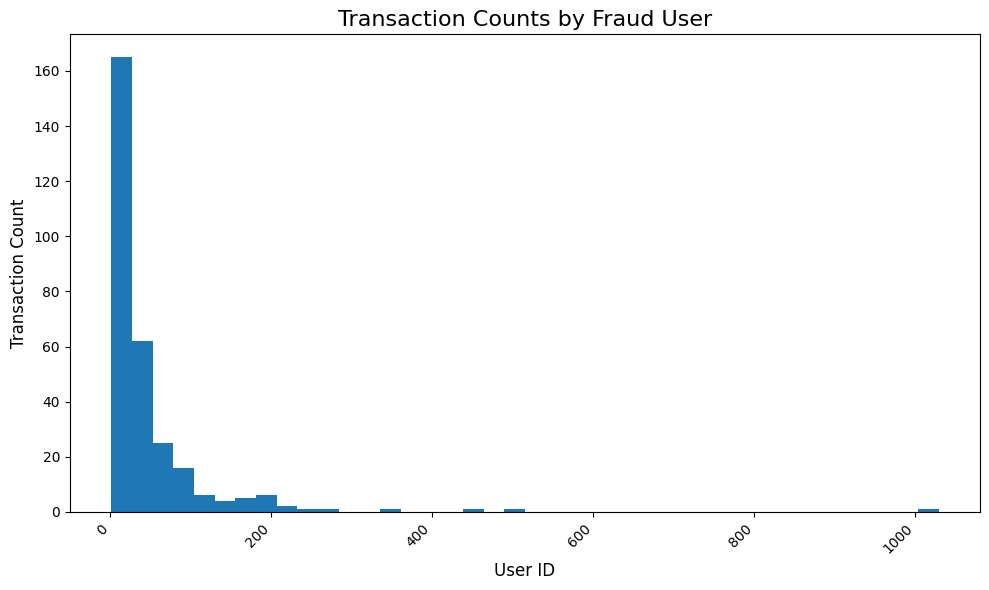

In [ ]:
# Number of transactions by fraud vs non-fraud users
transaction_counts = df_eda_t.query('is_fraud == 1').groupby('user_id')['transaction_id'].count()
transaction_counts.plot(kind='hist', figsize=(10, 6), bins=40)  # Adjust figsize as needed

plt.title('Transaction Counts by Fraud User', fontsize=16)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.tight_layout()                                # Adjust layout to prevent overlapping

plt.show()

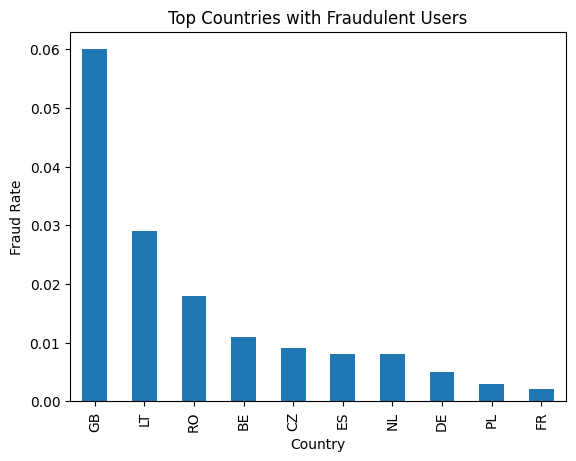

In [ ]:
# What are the top countries associated with fraud?
eda_categorical(df=df_eda, feature='country', target='is_fraud', sorted_on='is_fraud', filter=10)['is_fraud'].plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Fraud Rate')
plt.title('Top Countries with Fraudulent Users')
plt.show()

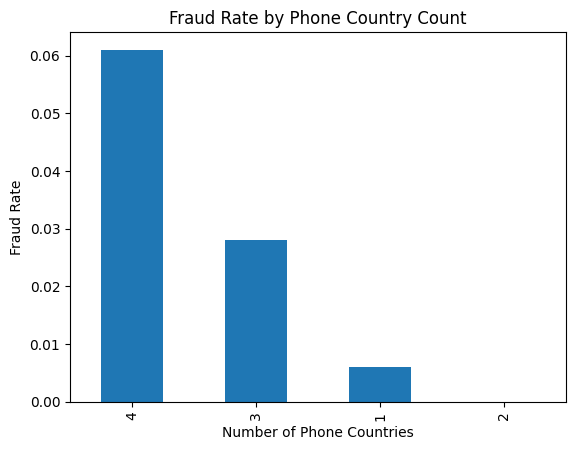

In [ ]:
# Are the number of phone countries associated with fraudulent behaviorals?
df_eda['phone_country_count'] = df_eda['phone_country'].apply(lambda x: len(x.split('||')))#.value_counts()
eda_categorical(df=df_eda, feature='phone_country_count', target='is_fraud', sorted_on='is_fraud', filter=10)['is_fraud'].plot(kind='bar')
plt.xlabel('Number of Phone Countries')
plt.ylabel('Fraud Rate')
plt.title('Fraud Rate by Phone Country Count')
plt.show()

In [ ]:
# Do fraudsters have more volatility in their spending patterns?
df_eda_t.groupby('is_fraud')['amount_usd'].agg(['mean', 'std']).round(3)

,mean,std
is_fraud,,
0,7586247.931,2.360197e+09
1,62614.179,1.995497e+06


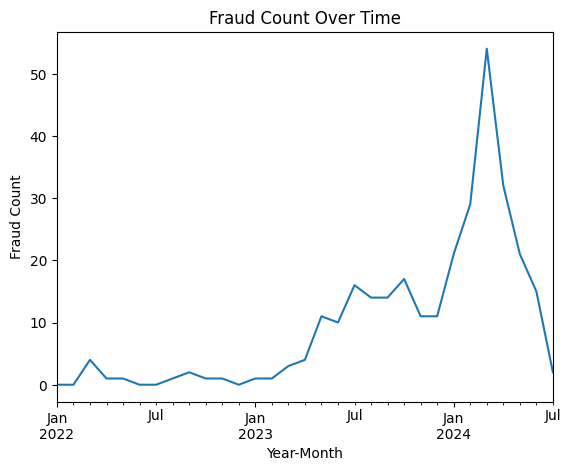

In [ ]:
# User fraud count overtime
df_eda['year_month'] = df_eda['created_date'].dt.to_period('M')
df_eda.groupby('year_month')['is_fraud'].sum().plot()
plt.xlabel('Year-Month')
plt.ylabel('Fraud Count')
plt.title('Fraud Count Over Time')
plt.show()

If the model is productionised, we want to know what is the actual performance of the model. The best way to emaulate that is not randomly sample 10% or 20% across the data history. As we mentioned once the model is in production it predicts on the most recent data.

Ideally we want to leave out most recent slides of data as a test dataset and the rest is our train and validation dataset.

#3 - Data Preparation
*   Format Fields: Ensure data types are appropriate for analysis (e.g., datetime, categorical).
*   Split Data: Divide the dataset into training and testing sets to evaluate model performance robustly.

## Merge Tables

In [ ]:
# Set select fields as datetime data type
df_users['created_date'] = pd.to_datetime(df_users['created_date'])
df_transactions['created_date'] = pd.to_datetime(df_transactions['created_date'])

# Merge users with transaction data
df = (
    df_users
        .merge(df_transactions, how='right', left_on='id', right_on='user_id', suffixes=('','_transactions'))
        .drop('user_id', axis=1)
        .rename(columns={
            'created_date_transactions': 'transaction_date',
            'created_date': 'sign_up_date',
            'id': 'user_id',
            'id_transactions': 'transaction_id'
        })
)

# Set variables as categorical
categorical_variables = [
    'phone_country','terms_version', 'country', 'kyc', 'state', 'merchant_category',
    'merchant_country', 'entry_method', 'type', 'source', 'currency'
]
for col in categorical_variables:
    df[col] = df[col].astype('category')
    # Add 'MISSING' as a new category
    df[col] = df[col].cat.add_categories('MISSING')
    df[col] = df[col].fillna('MISSING')

# Sort data based on the ascending order of transasction date
df.sort_values(by=['user_id','transaction_date'], ascending=True, inplace=True, ignore_index=True)

## Concat Categorical Variables

In [ ]:
# Concatenate Categorical Variables

def concat_categorical(df, cat_merged):
    """
    Concatenates specified categorical columns into new features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        cat_merged (dict): A dictionary mapping new feature names to lists of
                           existing categorical column names to be merged.

    Returns:
        pd.DataFrame: The DataFrame with the new merged features added.
    """

    for name, cols in cat_merged.items():
        df[name] = df[cols].astype(str).agg('-'.join, axis=1).astype('category')
    return df

cat_merged = {
    'cat_merge_1': ['phone_country', 'terms_version', 'country', 'kyc', 'state', 'has_email'],
    'cat_merge_2': ['merchant_category', 'merchant_country', 'entry_method', 'type', 'source', 'currency'],
    'cat_merge_3': ['country', 'merchant_country', 'phone_country']
}

df = concat_categorical(df, cat_merged)

categorical_merge_variables = list(cat_merged.keys())

## Split Data

In [ ]:
# Split on users that came after the split date
split_date = '2024-05-01'
df_train, df_test = df[df.sign_up_date < split_date], df[df.sign_up_date >= split_date]

# Split train into 10% valid and 90% train based on randomly sampled users
df_train_users = df_train.user_id.unique()
df_train_users = np.random.choice(df_train_users, size=int(len(df_train_users) * 0.9), replace=False)

df_val = df_train[~df_train.user_id.isin(df_train_users)]
df_train = df_train[df_train.user_id.isin(df_train_users)]

# Reset index
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

df_train.name = 'train'
df_val.name = 'val'
df_test.name = 'test'

for _df in [df_train, df_val, df_test]:
    print(f"{_df.name} Shape: {_df.shape}")

train Shape: (541925, 24)
val Shape: (60662, 24)
test Shape: (36155, 24)


In [ ]:
# Split data into X and y frames
X_train = df_train.drop(columns=['is_fraud'])
y_train = df_train['is_fraud']
X_val = df_val.drop(columns=['is_fraud'])
y_val = df_val['is_fraud']
X_test = df_test.drop(columns=['is_fraud'])
y_test = df_test['is_fraud']

# Get shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

# Fraud rates
print(f"Train Fraud Rate: {y_train.mean():.4f}")
print(f"Val Fraud Rate: {y_val.mean():.4f}")
print(f"Test Fraud Rate: {y_test.mean():.4f}")

X_train Shape: (541925, 23)
y_train Shape: (541925,)
X_val Shape: (60662, 23)
y_val Shape: (60662,)
X_test Shape: (36155, 23)
y_test Shape: (36155,)
Train Fraud Rate: 0.0224
Val Fraud Rate: 0.0114
Test Fraud Rate: 0.0302


#4 - Feature Engineering

1. **Dummy Encoding**: Consider applying dummy encoding on categorical variables. But beaware of sparsity!
2. **Decompose Timestamps**: Decompose timestamp into year, month, day of year, and such.
3. **Aggregations**: Consider aggregating $ amount to profile transaction history of users.

We need to extract as many features as possible in a quick and efficient manner instead of extracting one feature at the time

## Dummy Encoding

We're using dummy encoding as a stepping stone to extract additional features. The underlying assumption is that users who have multiple transactions that are associated with a certain `state` or certain `type`. There might be a high percentage of multiple transactional occurences of users with `state_Failed` which could associated with a fraud behaviour.

In [ ]:
# Store the dummy DataFrames in separate variables before concatenating
train_dummies_all = pd.DataFrame()
val_dummies_all = pd.DataFrame()
test_dummies_all = pd.DataFrame()

for col in categorical_variables:
    # Get dummies for the current column
    train_dummies = pd.get_dummies(X_train[col], prefix=f'one_hot__{col}', prefix_sep='_', dtype=float)
    val_dummies = pd.get_dummies(X_val[col], prefix=f'one_hot__{col}', prefix_sep='_', dtype=float)
    test_dummies = pd.get_dummies(X_test[col], prefix=f'one_hot__{col}', prefix_sep='_', dtype=float)

    # Concatenate dummies to the respective _all DataFrames
    train_dummies_all = pd.concat([train_dummies_all, train_dummies], axis=1)
    val_dummies_all = pd.concat([val_dummies_all, val_dummies], axis=1)
    test_dummies_all = pd.concat([test_dummies_all, test_dummies], axis=1)

    # Concatenate dummies to the original DataFrame (this part was already in the code)
    X_train = pd.concat([X_train, train_dummies], axis=1)
    X_val = pd.concat([X_val, val_dummies], axis=1)
    X_test = pd.concat([X_test, test_dummies], axis=1)


# Get shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (541925, 639)
y_train Shape: (541925,)
X_val Shape: (60662, 639)
y_val Shape: (60662,)
X_test Shape: (36155, 639)
y_test Shape: (36155,)


## Compute Aggregations

The aggregation works at the per user level across the time history, binning past past 7 & 30 days.

In [ ]:
def auto_aggregation(df, user_id_col, date_col, value_cols, windows, fillna=-999):
    """
    Efficiently performs aggregations for different time windows using pandas groupby and transform.

    Args:
        df (pd.DataFrame): Input DataFrame.
        user_id_col (str): Column name for user ID.
        date_col (str): Column name for transaction date.
        value_col (str): Column name for value to aggregate.
        windows (list): List of time windows in days.

    Returns:
        pd.DataFrame: DataFrame with aggregation columns added.
    """

    df = df.copy()
    df = df.sort_values(by=[user_id_col, date_col])

    for dtype, cols in value_cols.items():

        print(f'Processing {dtype} columns...')

        # return df.reset_index(drop=True)
        for col in tqdm(cols):

            # Initialize aggregation columns
            for window in windows:

                # Define rolling window aggregation per user
                rolling_group = df.groupby(user_id_col).rolling(window=f"{window}D", on=date_col)

                if dtype == 'id':
                    df[f'agg__count_{col}_{window}D'] = rolling_group[col].count().fillna(fillna).values
                # for numeric we apply set of aggeration functions
                if dtype == 'numeric':
                    df[f'agg__mean_{col}_{window}D'] = rolling_group[col].mean().fillna(fillna).values
                    df[f'agg__sum_{col}_{window}D'] = rolling_group[col].sum().fillna(fillna).values
                    df[f'agg__std_{col}_{window}D'] = rolling_group[col].std().fillna(fillna).values

                if dtype == 'boolean':
                    df[f'agg__prop_{col}_{window}D'.replace('one_hot__','')] = rolling_group[col].mean().fillna(fillna).values

    return df.reset_index(drop=True)

windows = [7, 30]
val_settings = {
    'boolean': ['one_hot__state_COMPLETED', 'one_hot__state_DECLINED', 'one_hot__state_FAILED',
                'one_hot__state_PENDING', 'one_hot__state_REVERTED', 'one_hot__type_BANK_TRANSFER',
                'one_hot__type_CARD_PAYMENT', 'one_hot__type_P2P', 'one_hot__type_TOPUP', 'one_hot__type_ATM'],
    'numeric': ['amount_usd'],
    'id': ['transaction_id']
}

X_train = auto_aggregation(X_train, 'user_id', 'transaction_date', val_settings, windows)
X_val = auto_aggregation(X_val, 'user_id', 'transaction_date', val_settings, windows)
X_test = auto_aggregation(X_test, 'user_id', 'transaction_date', val_settings, windows)

Processing boolean columns...


100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


Processing numeric columns...


100%|██████████| 1/1 [00:27<00:00, 27.49s/it]


Processing id columns...


100%|██████████| 1/1 [00:10<00:00, 10.97s/it]


Processing boolean columns...


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Processing numeric columns...


100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


Processing id columns...


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Processing boolean columns...


100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Processing numeric columns...


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Processing id columns...


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


## Decompose TS

In [ ]:
# Here we decompose the datetime variable
def decompose_datetime(df: pd.DataFrame, date_column: list):
    """
    Decomposes datetime columns into individual time features.

    Args:
        df (pd.DataFrame): The input DataFrame.
        date_column (list): List of datetime columns to decompose.

    Returns:
        pd.DataFrame: The DataFrame with added time features.
    """
    for field in date_column:
        # Extract datetime properties using the .dt accessor
        dt_series = df[field].dt

        # Create new columns for year, month, day, dayofweek, dayofyear
        df.loc[:, 'ts__' + field + '_year'] = dt_series.year
        df.loc[:, 'ts__' + field + '_month'] = dt_series.month
        df.loc[:, 'ts__' + field + '_day'] = dt_series.day
        df.loc[:, 'ts__' + field + '_dayofweek'] = dt_series.dayofweek
        df.loc[:, 'ts__' + field + '_dayofyear'] = dt_series.dayofyear
        df.loc[:, 'ts__' + field + '_hour'] = dt_series.hour
        df.loc[:, 'ts__' + field + '_minute'] = dt_series.minute
        df.loc[:, 'ts__' + field + '_second'] = dt_series.second

    return df

# Decompose datetime in train
X_train = decompose_datetime(X_train, ['sign_up_date', 'transaction_date'])
X_val = decompose_datetime(X_val, ['sign_up_date', 'transaction_date'])
X_test = decompose_datetime(X_test, ['sign_up_date', 'transaction_date'])

## Weight of Evidence (WoE)

The ratio of fraud between each of a categorical value.
Users are in a a certain buckets that are highly associated with the fraud, which means high WoE (positive value). Whereas certain categorical values that have low association with the fraud will have a negative WoE value.

In [ ]:
class WoEEncoder:
    def __init__(self):
        self.woe_dict = {}

    def fit(self, X, y):
        """
        Fit WoE encoder.

        Positive WoE → category associated with higher fraud risk.
        Negative WoE → category associated with lower fraud risk.
        WoE close to zero → category doesn't distinguish fraud from non-fraud.

        Args:
            X (pd.Series): Categorical feature to encode.
            y (pd.Series): Binary target variable (0/1).
        """
        df = pd.DataFrame({'feature': X, 'target': y})
        eps = 0.0001  # to prevent division by zero

        grouped = df.groupby('feature')['target']
        event = grouped.sum()
        non_event = grouped.count() - event

        event_rate = event / event.sum()
        non_event_rate = non_event / non_event.sum()

        woe = np.log((event_rate + eps) / (non_event_rate + eps))

        self.woe_dict = woe.to_dict()

    def transform(self, X):
        """
        Transform categorical feature to WoE.

        Args:
            X (pd.Series): Categorical feature.

        Returns:
            pd.Series: WoE encoded feature.
        """
        # Convert the input to a pandas Series if it's not already
        X = pd.Series(X)

        # Add 0 to the categories if it's not already present
        if 'NEW' not in X.cat.categories:
            X = X.cat.add_categories(['NEW'])

        X = X.fillna('NEW')

        return X.map(self.woe_dict)

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

for col in categorical_variables + categorical_merge_variables:
    woe_encoder = WoEEncoder()
    X_train['woe__'+col] = woe_encoder.fit_transform(X_train[col], y_train.values.ravel())
    X_val['woe__'+col] = woe_encoder.transform(X_val[col])
    X_test['woe__'+col] = woe_encoder.transform(X_test[col])

## Add Transaction Number

We're adding transaction number because when we do slicing we predict on the 9th transactional point


In [ ]:
# Add row number of observation within user
X_train['feat__transaction_number'] = X_train.groupby('user_id').cumcount() + 1
X_val['feat__transaction_number'] = X_val.groupby('user_id').cumcount() + 1
X_test['feat__transaction_number'] = X_test.groupby('user_id').cumcount() + 1

## Number of Distinct Phone IDs

In [ ]:
# We're splitting phone country codes that were groupped with `||` characters.
# The distinct phone codes may be associated with a fraud.
X_train['feat__phone_country_count'] = X_train['phone_country'].apply(lambda x: len(x.split('||')))
X_val['feat__phone_country_count'] = X_val['phone_country'].apply(lambda x: len(x.split('||')))
X_test['feat__phone_country_count'] = X_test['phone_country'].apply(lambda x: len(x.split('||')))

In [ ]:
# Get shapes
print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_val Shape: {X_val.shape}")
print(f"y_val Shape: {y_val.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

# Fraud rate
print(f"Train Fraud Rate: {y_train.mean():.4f}")
print(f"Val Fraud Rate: {y_val.mean():.4f}")
print(f"Test Fraud Rate: {y_test.mean():.4f}")

X_train Shape: (541925, 699)
y_train Shape: (541925,)
X_val Shape: (60662, 699)
y_val Shape: (60662,)
X_test Shape: (36155, 699)
y_test Shape: (36155,)
Train Fraud Rate: 0.0224
Val Fraud Rate: 0.0114
Test Fraud Rate: 0.0302


#5 - Feature Selection

Feature selection prevents model overfitting and improves training speed.


1.   identify relevant features for model
2.   account for multicollinearity

We want to optimised most important features that are not collinear to each other.


## Specify Transaction Number

In [ ]:
# Filter predictor data based on the selected features
train_filter = X_train.feat__transaction_number == 9
val_filter = X_val.feat__transaction_number == 9
test_filter = X_test.feat__transaction_number == 9

X_train_subset = X_train[train_filter].reset_index(drop=True)
X_val_subset = X_val[val_filter].reset_index(drop=True)
X_test_subset = X_test[test_filter].reset_index(drop=True)

y_train_subset = y_train[train_filter].reset_index(drop=True)
y_val_subset = y_val[val_filter].reset_index(drop=True)
y_test_subset = y_test[test_filter].reset_index(drop=True)

# Get shapes
print(f"X_train Shape: {X_train_subset.shape}")
print(f"y_train Shape: {y_train_subset.shape}")
print(f"X_val Shape: {X_val_subset.shape}")
print(f"y_val Shape: {y_val_subset.shape}")
print(f"X_test Shape: {X_test_subset.shape}")
print(f"y_test Shape: {y_test_subset.shape}")

# Fraud rate
print(f"Train Fraud Rate: {y_train_subset.mean():.4f}")
print(f"Val Fraud Rate: {y_val_subset.mean():.4f}")
print(f"Test Fraud Rate: {y_test_subset.mean():.4f}")

X_train Shape: (4051, 699)
y_train Shape: (4051,)
X_val Shape: (450, 699)
y_val Shape: (450,)
X_test Shape: (818, 699)
y_test Shape: (818,)
Train Fraud Rate: 0.0484
Val Fraud Rate: 0.0444
Test Fraud Rate: 0.0318


## Feature Importance

In [ ]:
exclude_variables = ['user_id',
 'has_email',
 'is_fraudster',
 'sign_up_date',
 'amount',
 'transaction_date',
 'transaction_id',
] + categorical_variables + categorical_merge_variables

candidate_features = [col for col in X_train_subset.columns if col not in exclude_variables]
len(candidate_features)

680

This is univariate classification approach - we're using this simple classification model per each feature vs actual target, to get a features based on their importance.

In [ ]:
# Initialize SelectKBest with f_regression as the ranking function
selector = SelectKBest(f_classif, k=200)

# Fit SelectKBest to the encoded training data
selector = selector.fit(X_train_subset[candidate_features].fillna(0), y_train_subset)

# Get the selected features
selected_features = np.array(candidate_features)[selector.get_support()].tolist()
print(f"Selected features (Size: {len(selected_features)}): {selected_features}")

Selected features (Size: 200): ['birth_year', 'one_hot__phone_country_AT', 'one_hot__phone_country_BE', 'one_hot__phone_country_BG', 'one_hot__phone_country_CH', 'one_hot__phone_country_CY', 'one_hot__phone_country_CZ', 'one_hot__phone_country_DE', 'one_hot__phone_country_DK', 'one_hot__phone_country_ES', 'one_hot__phone_country_FR', 'one_hot__phone_country_GB||JE||IM||GG', 'one_hot__phone_country_GI', 'one_hot__phone_country_GR', 'one_hot__phone_country_HU', 'one_hot__phone_country_IE', 'one_hot__phone_country_IT', 'one_hot__phone_country_LT', 'one_hot__phone_country_LV', 'one_hot__phone_country_MT', 'one_hot__phone_country_NL', 'one_hot__phone_country_NO||SJ||BV', 'one_hot__phone_country_PL', 'one_hot__phone_country_PT', 'one_hot__phone_country_SE', 'one_hot__phone_country_SI', 'one_hot__phone_country_US||PR||CA', 'one_hot__terms_version_2023-01-15', 'one_hot__terms_version_2023-02-01', 'one_hot__terms_version_2023-12-31', 'one_hot__terms_version_2024-01-12', 'one_hot__terms_version_

In [ ]:
# Get feature scores and p-values
feature_scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame to display feature rankings
df_feature_ranking = pd.DataFrame({'Feature': candidate_features,
                                   'Score': feature_scores,
                                   'P-value': p_values})

# Filter the feature ranking DataFrame to include only selected features
df_selected_features = (
    df_feature_ranking[df_feature_ranking['Feature'].isin(selected_features)]
        .sort_values(by='Score', ascending=False)
        .reset_index(drop=True)
        .head(100)
)


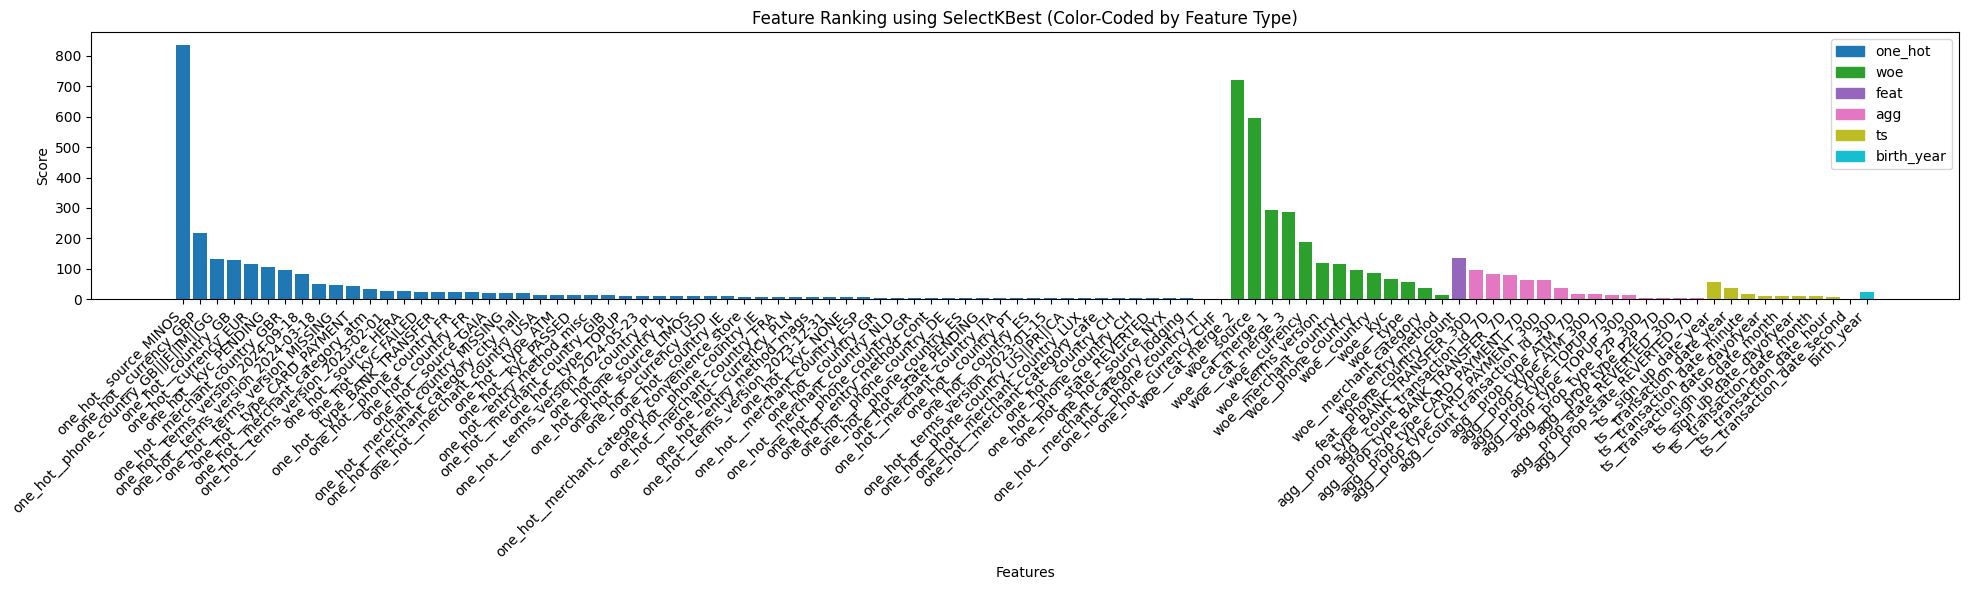

In [ ]:
# Get feature scores and p-values
feature_scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame to display feature rankings
df_feature_ranking = pd.DataFrame({'Feature': candidate_features,
                                   'Score': feature_scores,
                                   'P-value': p_values})
# new columns stores the type of feature engineering that was applied to create each feature
df_feature_ranking['feature_type'] = (
    df_feature_ranking['Feature']
        .apply(lambda x: x.split('__')[0])
)
# new df sorted by ranking in DESC based of 'Score', selecting top 100 features
df_feature_expore = df_feature_ranking.sort_values(by='Score', ascending=False).head(100)

# Get unique feature types and assign colors
feature_types = df_feature_expore['feature_type'].unique()
colors = plt.cm.get_cmap('tab10', len(feature_types))  # Use a colormap for distinct colors

# Create the bar plot with color-coding
plt.figure(figsize=(20, 6))
for i, feature_type in enumerate(feature_types):
    subset = df_feature_expore[df_feature_expore['feature_type'] == feature_type]
    plt.bar(subset['Feature'], subset['Score'], color=colors(i), label=feature_type)

plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('Feature Ranking using SelectKBest (Color-Coded by Feature Type)')
plt.tight_layout()

# Create custom legend handles
legend_handles = [mpatches.Patch(color=colors(i), label=feature_type) for i, feature_type in enumerate(feature_types)]
plt.legend(handles=legend_handles)  # Add the legend

plt.show()

These features are most likely relatively collinear to each other. The way to mitigatge that is `Feature Clustering`.

Features that are relatively similar to each other, they would have similar correlation values with the target feature across all of the features.

## Feature Clustering

We use aggregation features because 7 & 30 day window will most likely be collinear to each other and WOE should no be consequential so we leave it as it is.

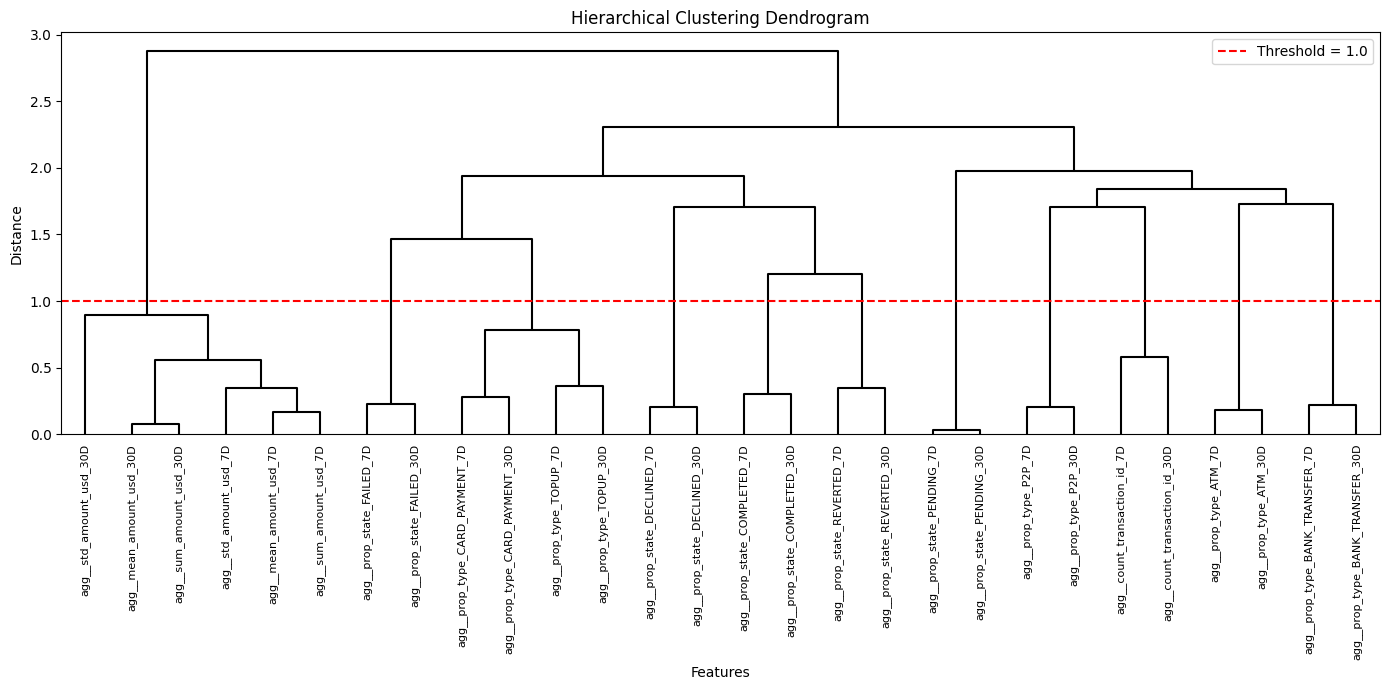

In [ ]:
# Select agg features
agg_features = X_train_subset.filter(like='agg__').columns.tolist()

# 1. Subset the data to include only the selected features:
X_subset = X_train_subset[agg_features].fillna(0)

# 2. Calculate the correlation matrix:
corr_matrix = X_subset.corr().fillna(0)

# 3. Calculate the distance matrix (1 - correlation):
distance_matrix = 1 - np.abs(corr_matrix)

# 4. Perform hierarchical clustering:
linkage_matrix = hierarchy.linkage(pdist(distance_matrix), method='complete')

# 5. Set a threshold for clustering:
threshold = 1.0 # You might need to adjust this value

# 6. Get cluster labels:
cluster_labels = hierarchy.fcluster(linkage_matrix, t=threshold, criterion='distance')

# 7. Create a dictionary to map features to clusters:
cluster_dict = {feature: cluster for feature, cluster in zip(agg_features, cluster_labels)}

# after we receive what cluster tags are, we append it to df_feature_ranking
df_feature_ranking = df_feature_ranking.set_index('Feature').join(pd.Series(cluster_dict, name='cluster'))
df_feature_ranking['cluster_rank'] = df_feature_ranking.groupby('cluster')['Score'].rank(ascending=False)
df_feature_ranking = df_feature_ranking.reset_index()

# 8. Select one feature from each cluster:
grouped_features = {}
for feature, value in cluster_dict.items():
    if value not in grouped_features:
        grouped_features[value] = []
    grouped_features[value].append(feature)

# Visualize the dendrogram
plt.figure(figsize=(14, 7))  # Adjust figure size as needed
dendrogram = hierarchy.dendrogram(linkage_matrix, orientation='top', labels=agg_features,
                                  leaf_rotation=90, leaf_font_size=8, link_color_func=lambda k: 'black')

plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Features')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

## Select Features

We're selecting the final set of features Based on the previous feature engineering and selection steps `Feature Importance` and `Feature Clustering`, the code now combines different types of features to create a robust feature set for the model. The result is 42 features we can work off.

In [ ]:
# selects the top-ranked feature within each cluster=1 identified during the feature clustering step
agg_features = df_feature_ranking[df_feature_ranking['cluster_rank'] == 1]['Feature'].tolist()

# collects all columns from the X_train DataFrame whose names contain the string 'woe__'
woe_features = X_train.filter(like='woe__').columns.tolist()

# selects the top 20 features based on their 'Score' that have the feature_type of 'one_hot
onehot_features = df_feature_ranking[df_feature_ranking.feature_type == 'one_hot'].sort_values('Score', ascending=False)['Feature'].head(20).tolist()

# selects the top 3 timestamp features of 'ts' type
ts_features = df_feature_ranking[df_feature_ranking.feature_type == 'ts'].sort_values('Score', ascending=False)['Feature'].head(3).tolist()

# explicitly includes a few specific features
recent_features = ['has_email','failed_sign_in_attempts','amount_usd','feat__transaction_number','feat__phone_country_count']

# selected_features = recent_features

# all combined into a single list
selected_features = woe_features + onehot_features + ts_features + recent_features
print(f'Number of features: {len(selected_features)}')

X_train_model = X_train_subset[selected_features]
X_val_model = X_val_subset[selected_features]
X_test_model = X_test_subset[selected_features]
y_train_model = y_train_subset
y_val_model = y_val_subset
y_test_model = y_test_subset

# Get shapes
print(f"X_train_model Shape: {X_train_model.shape}")
print(f"X_test_model Shape: {X_test_model.shape}")
print(f"X_val_model Shape: {X_val_model.shape}")

print(f"y_train_model Shape: {y_train_model.shape}")
print(f"y_val_model Shape: {y_val_model.shape}")
print(f"y_test_model Shape: {y_test_model.shape}")

# Fraud rate
print(f"Train Fraud Rate: {y_train_model.mean():.4f}")
print(f"Val Fraud Rate: {y_val_model.mean():.4f}")
print(f"Test Fraud Rate: {y_test_model.mean():.4f}")

Number of features: 42
X_train_model Shape: (4051, 42)
X_test_model Shape: (818, 42)
X_val_model Shape: (450, 42)
y_train_model Shape: (4051,)
y_val_model Shape: (450,)
y_test_model Shape: (818,)
Train Fraud Rate: 0.0484
Val Fraud Rate: 0.0444
Test Fraud Rate: 0.0318


#6 - Model Selection

1. **Baseline Model**: Start by establishing a baseline performance benchmark with a simple yet effective model like XGBoost. This sets a foundation to compare against when exploring more complex approaches.

2. **Hyperparameter Tuning**: Fine-tune the parameters of  the model using grid search or random search to unlock its full potential and achieve optimal performance.

## Baseline Model

In [ ]:
# Initialize and train the XGBoost classifier
baseline_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=30,
    learning_rate=0.1,
    max_depth=10,
    random_state=SEED,
    enable_categorical=True,
    use_label_encoder=False,
    eval_metric='logloss'
)

baseline_model.fit(X_train_model, y_train_model)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=30,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [ ]:
# Get predicted probabilities for the positive class
y_pred_train_proba = baseline_model.predict_proba(X_train_model)[:, 1]
y_pred_val_proba = baseline_model.predict_proba(X_val_model)[:, 1]
y_pred_test_proba = baseline_model.predict_proba(X_test_model)[:, 1]

# Calculate ROC-AUC scores
auc_train = roc_auc_score(y_train_model, y_pred_train_proba)
auc_val = roc_auc_score(y_val_model, y_pred_val_proba)
auc_test = roc_auc_score(y_test_model, y_pred_test_proba)

# Print rounded AUC scores
print("ROC-AUC Scores:")
for name, auc in zip(['Train','Val', 'Test'], [auc_train, auc_val, auc_test]):
    print(f"{name}: {auc:.4f}")

ROC-AUC Scores:
Train: 0.9983
Val: 0.9593
Test: 0.9384


## Hyperparameter Tuning

Building a fraud model on a heavily imbalanced dataset without appropriate handling techniques can lead to a model that performs poorly on the minority class, effectively ignoring the fraudsters in certain user segments.

RandomUnderSampler is a good step towards mitigating this issue.

In [ ]:
np.random.seed(SEED)

# Define pipeline with placeholder
pipeline = Pipeline([
    ('sampler', RandomUnderSampler(random_state=SEED)),
    ('classifier', xgb.XGBClassifier(
        objective='binary:logistic',
        enable_categorical=True,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=SEED
    ))
])

# Hyperparameter space with undersampling ratios
param_dist = {
    # Varying undersampling ratios - 10% or 80% fraud and rest non-fraud
    'sampler__sampling_strategy': np.linspace(0.1, 0.8, 20),

    # XGBoost hyperparameters
    'classifier__n_estimators': np.arange(100, 310, 50),
    'classifier__max_depth': np.arange(10, 15),
    'classifier__learning_rate': np.linspace(0.001, 0.1, 30),
    'classifier__subsample': np.linspace(0.5, 1.0, 10),
    'classifier__colsample_bytree': np.linspace(0.5, 1.0, 10),
    'classifier__gamma': np.linspace(0, 5, 10),
    'classifier__min_child_weight': np.arange(1, 10),
    'classifier__reg_alpha': np.logspace(-4, 1, 20), # regularisation alpha & lambda
    'classifier__reg_lambda': np.logspace(-4, 1, 20), # both help reduce overfitting
}

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=500,  # Adjust as needed
    scoring='roc_auc',
    cv=5,
    verbose=10,
    n_jobs=-1,
    random_state=SEED
)

# Run randomized search
random_search.fit(X_train_model, y_train_model)

# Output best parameters and score
print("Best parameters found:", random_search.best_params_)
print(f"Best ROC-AUC (CV): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters found: {'sampler__sampling_strategy': np.float64(0.1368421052631579), 'classifier__subsample': np.float64(0.5), 'classifier__reg_lambda': np.float64(0.07847599703514607), 'classifier__reg_alpha': np.float64(0.0006158482110660267), 'classifier__n_estimators': np.int64(250), 'classifier__min_child_weight': np.int64(1), 'classifier__max_depth': np.int64(14), 'classifier__learning_rate': np.float64(0.031724137931034485), 'classifier__gamma': np.float64(1.1111111111111112), 'classifier__colsample_bytree': np.float64(0.5)}
Best ROC-AUC (CV): 0.9743


In [ ]:
# Access and display all parameters and scores
results = pd.DataFrame(random_search.cv_results_)
results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

,params,mean_test_score,std_test_score,rank_test_score
77,{'sampler__sampling_strategy': 0.1368421052631...,0.974334,0.002402,1
349,{'sampler__sampling_strategy': 0.1368421052631...,0.973797,0.003360,2
288,{'sampler__sampling_strategy': 0.1368421052631...,0.973630,0.004426,3
186,{'sampler__sampling_strategy': 0.1736842105263...,0.973141,0.006159,4
478,{'sampler__sampling_strategy': 0.1368421052631...,0.973075,0.004151,5
...,...,...,...,...
281,{'sampler__sampling_strategy': 0.2842105263157...,0.952974,0.009721,496
153,{'sampler__sampling_strategy': 0.7263157894736...,0.952650,0.012177,497
329,{'sampler__sampling_strategy': 0.3578947368421...,0.952544,0.008527,498
359,{'sampler__sampling_strategy': 0.4684210526315...,0.950211,0.010423,499


In [ ]:
# Evaluate best model on validation/test sets
best_model = random_search.best_estimator_

y_train_proba = best_model.predict_proba(X_train_model)[:, 1]
y_val_proba = best_model.predict_proba(X_val_model)[:, 1]
y_test_proba = best_model.predict_proba(X_test_model)[:, 1]

auc_train = roc_auc_score(y_train_model, y_train_proba)
auc_val = roc_auc_score(y_val_model, y_val_proba)
auc_test = roc_auc_score(y_test_model, y_test_proba)

print("ROC-AUC Scores:")
print(f"Train AUC: {auc_train:.4f}")
print(f"Val AUC: {auc_val:.4f}")
print(f"Test AUC: {auc_test:.4f}")

ROC-AUC Scores:
Train AUC: 0.9933
Val AUC: 0.9666
Test AUC: 0.9393


There is improved Test and Validation score in comparison with cross-validation.

## Model Feature Importance

                                  Feature  Importance
14                  one_hot__source_MINOS    0.093324
12                       woe__cat_merge_2    0.083883
20          one_hot__merchant_country_GBR    0.074184
15                  one_hot__currency_GBP    0.063070
13                       woe__cat_merge_3    0.057313
11                       woe__cat_merge_1    0.045952
21      one_hot__terms_version_2024-09-18    0.045053
6                   woe__merchant_country    0.041519
9                             woe__source    0.041428
1                      woe__terms_version    0.028520
3                                woe__kyc    0.027312
17                    one_hot__country_GB    0.027104
16  one_hot__phone_country_GB||JE||IM||GG    0.026882
10                          woe__currency    0.024925
34                  ts__sign_up_date_year    0.024322
35              ts__transaction_date_year    0.023458
32                   one_hot__source_GAIA    0.022677
33      one_hot__merchant_co

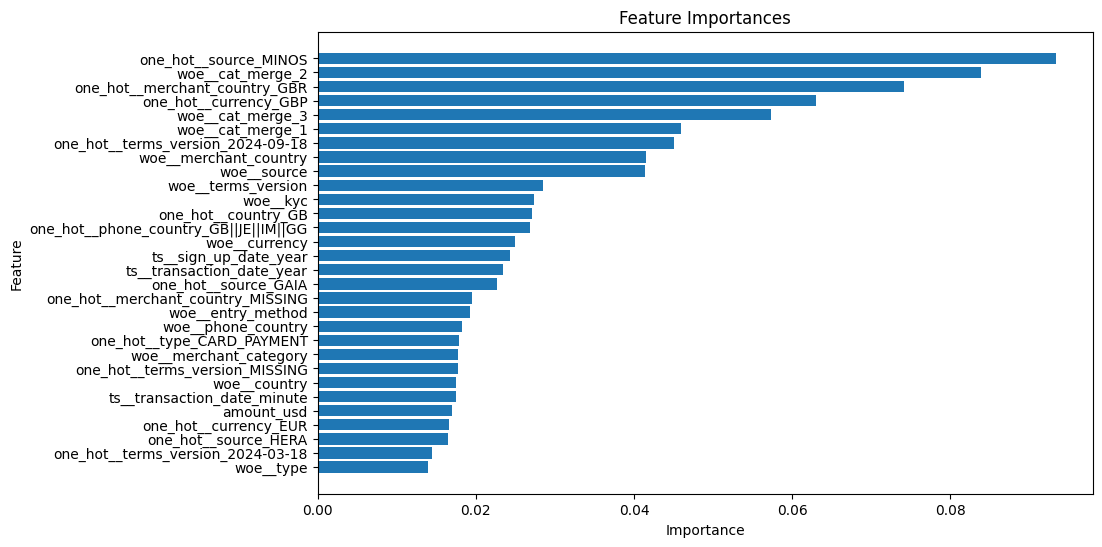

In [ ]:
# Model Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_  # Access the 'classifier' step in your pipeline
feature_names = X_train_model.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display or plot the feature importances
filter_imp = importance_df.head(30)
print(filter_imp)

plt.figure(figsize=(10, 6))
plt.barh(filter_imp['Feature'], filter_imp['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

It helps to understand which features the model considered most influential in making its predictions about fraudulent users. Features with higher importance scores had a greater impact on the model's decisions

#7 - Evaluation

We test and determine models true performance. We assess how well the model model generalises to unseen data.

1. **Precision & Recall:**  

      * **Precision** - what % of customers labelled as fraud is an actual fraud

      * **Recall** - out of the all the users known as fraud what % of them have we actually detected?

2. **Fraud Loss:** What is the total $ fraud loss mitigated by the model had this been productionized?

## Define Threshold

We're calculating precision and recall and doing parameters tweaks on validation set to avoid any data leakage.

As we increase the probability threshold we should see precision going up and recall is steadily going down.

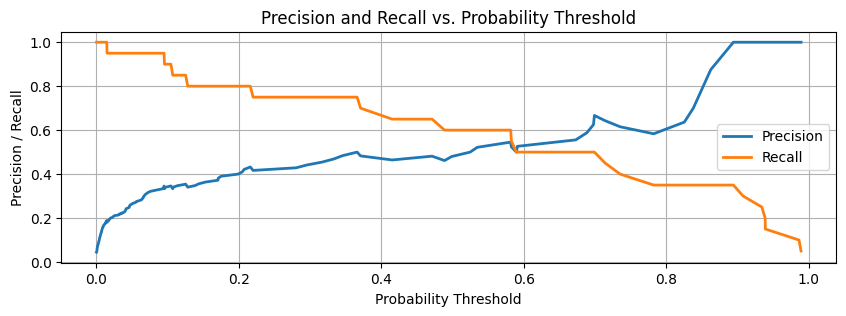

In [ ]:
# Get predicted probabilities from your best model
y_pred_proba = best_model.predict_proba(X_val_model)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_val_model, y_pred_proba)

# Plot precision and recall vs. thresholds
plt.figure(figsize=(10, 3))
plt.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
plt.xlabel('Probability Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision and Recall vs. Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create a DataFrame
pr_df = pd.DataFrame({
    'threshold': np.append(thresholds, 1.0),
    'precision': precision,
    'recall': recall
})

# Inspect the DataFrame
pr_df.sort_values('threshold', ascending=False).head(50)

,threshold,precision,recall
450,1.000000,1.000000,0.00
449,0.989044,1.000000,0.05
448,0.986170,1.000000,0.10
447,0.938882,1.000000,0.15
446,0.938674,1.000000,0.20
445,0.934019,1.000000,0.25
444,0.907775,1.000000,0.30
443,0.894114,1.000000,0.35
442,0.862308,0.875000,0.35
441,0.848682,0.777778,0.35


In [ ]:
# Copy the test dataset to create an evaluation dataset
df_eval = X_test_subset.copy().reset_index(drop=True)

# Set threshold
threshold = 0.7

# Store the prediction
df_eval = df_eval.assign(pred_proba=y_test_proba, pred_is_fraud=(y_test_proba >= threshold).astype(int), is_fraud=y_test_model.values)

# Apply TP, TN, FP, FN
def apply_label(row):
    if row['pred_is_fraud'] == 1 and row['is_fraud'] == 1:
        return 'TP'

    elif row['pred_is_fraud'] == 0 and row['is_fraud'] == 1:
        return 'FN'

    elif row['pred_is_fraud'] == 1 and row['is_fraud'] == 0:
        return 'FP'

    return 'TN'

df_eval['result'] = df_eval.apply(apply_label, axis=1)

# Get percentage
pd.concat([
    df_eval['result'].value_counts(),
    df_eval['result'].value_counts(normalize=True).round(3)
], axis=1)

,count,proportion
result,,
TN,789,0.965
TP,14,0.017
FN,12,0.015
FP,3,0.004


We have `96.5%` genuine users the model has correctly labelled them as non-fraud. True positive are fraud cases that model has labelled as fraud, that's about `1.7%`. The false positive cases `1.5%` those are users that have been falsly labelled as fraud and false negative cases `0.04%` are fraudsters that have been mislabelled as non-fraud users.

It does not give us a sense what the actual performance is in terms of monetary value.

## Calculate Fraud Loss in £

**What would be the actual savings of this model mitigating fraud cases?**

`Net Value` = `(TP * avg_spend)` + `(TN * avg_ltv)` - `(FN * avg_spend)` - `(FP * avg_ltv)`


In [ ]:
# Fraud loss calculation

# | Case | Meaning              | Cost/Benefit                         |
# |------|----------------------|--------------------------------------|
# | TP   | Fraudster caught     | ✅ Loss prevented (fraud avoided)     |
# | FP   | Good user blocked    | ❌ LTV lost (revenue sacrificed)      |
# | FN   | Fraudster missed     | ❌ Loss incurred (fraud executed)     |
# | TN   | Good user allowed    | ✅ LTV gained (revenue gained)        |

# *LTV = Lifetime value of user
# Net Value = (TP * avg_fraud_value) + (TN * avg_ltv) - (FN * avg_fraud_value) - (FP * avg_ltv)
# Assume LTV = SUM(amount GBP) * 2.8% transaction fee that Revolut charges per international transactions

df_net_value = df_test.sort_values(by=['user_id','transaction_date']).reset_index(drop=True)

df_net_value['cumsum_spend'] = df_net_value.groupby('user_id')['amount_gbp'].cumsum()
df_net_value['total_spend'] = df_net_value.groupby('user_id')['amount_gbp'].transform(lambda x: x.sum())
df_net_value['loss'] = df_net_value['total_spend'] - df_net_value['cumsum_spend']
df_net_value['ltv'] = df_net_value['loss'] * 0.028

df_net_value[df_net_value.user_id == '00131af8-66f0-4526-8b5f-dc2fdb26c7d7'][['user_id','transaction_date','amount_usd','cumsum_spend','total_spend','loss','ltv']]

,user_id,transaction_date,amount_usd,cumsum_spend,total_spend,loss,ltv
0,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-06-04 21:06:16.590,111,111,14574,14463,419.427
1,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-06-04 21:07:18.662,1112,1223,14574,13351,387.179
2,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-07-04 10:52:04.507,3338,4561,14574,10013,290.377
3,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-07-04 10:53:46.766,4118,8679,14574,5895,170.955
4,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-07-04 11:54:11.328,665,9344,14574,5230,151.670
5,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-07-04 12:12:30.428,1112,10456,14574,4118,119.422
6,00131af8-66f0-4526-8b5f-dc2fdb26c7d7,2024-07-04 12:16:44.927,4118,14574,14574,0,0.000


In [ ]:
# Merge result with eval and calculate net value
df_net_value = df_eval.merge(df_net_value[['user_id','transaction_id','loss','ltv']], how='left', on=['user_id','transaction_id'])

# Calculate net value
def calculate_net_value(row):
    if row['result'] == 'TP':
        return row['loss']
    elif row['result'] == 'FP':
        return -row['ltv']
    elif row['result'] == 'FN':
        return -row['loss']
    else:
        return row['ltv']

df_net_value['net_value'] = df_net_value.apply(calculate_net_value, axis=1)

In [ ]:
# Net Value Result
print('Net Value in Total:', df_net_value.net_value.sum().round(2))
df_net_value.groupby('result')['net_value'].sum().round(3).apply(lambda x: '{:.2f}'.format(x))

Net Value in Total: 540649322.07


,net_value
result,
FN,-15133780.00
FP,-32282.42
TN,535295717.49
TP,20519667.00


Total Net Value = `-£15,133,780.00` + `(-£32,282.61)` + `£535,295,717.49` + `£20,519,667.00` = `£540,649,322.07`

The estimation of total financial gain for Revolut by using the model to detect and mitigate fraudulent activities is `£540,649,322.07`. This gain is attributed to:

`Reduced fraud losses (TP)`: Preventing fraudulent transactions.

`Retained revenue (TN)`: Allowing genuine customers to continue using the platform.

`Minimized loss from incorrect classifications (FP & FN)`: While there's a small loss from blocking some genuine users (FP) and missing some fraudsters (FN), these losses are significantly outweighed by the overall benefits.

#8 - Operationalisation

**How will we utilise the model to catch fraudulent users? Automated system!**

We shouldn't send every user to the review team because manual reviews take a long time about `30` to `60` minutes each. To save time, we use automatic bans, but we also don't want to ban everyone automatically, especially if our system is only right about `40-60%` of the time and we can't get more reliable information.

* **Low precision (40–60%)** means `40–60%` of flagged cases are truly fraudulent. Automatically banning all flagged users would result in **40–60% false positives**, blocking legitimate users and damaging trust

* **Example**: A `40%` precision rate implies banning `100` users would incorrectly block `60` legitimate accounts

When fraudster is identified these actions will be taken: **LOCK_USER**, **ALERT_AGENT**, or **BOTH**.



*   **LOCK_USER** - The transaction is stopped and the user's account is frozen, preventing further transactions until the user contacts an agent to regain access. Access can only be restored after contacting an agent.
*   **ALERT_AGENT** -The transaction proceeds as normal, but an alert is sent to a human agent for further investigation.

In [ ]:
def predict(model, data):
	"""Generates prediction from trained model"""
	return model.predict_proba(data)[0][1]

def response(score, criterion):
	"""Sends out alert to OPs"""

	lock = criterion['lock']
	alert = criterion['alert']

	if score >= lock:
		return 'lock'
	if score >= alert:
		return 'alert'
	return 'pass'


# Dispatch auto-response
criterion = {
    'lock': 0.7,
    'alert': 0.4
}

for index in range(X_test.shape[0]):
    row = X_test.iloc[[index]]
    user_id = row['user_id'].values[0]

    if row['feat__transaction_number'].values[0] == 9:
        score = predict(best_model, row[selected_features])
        resp = response(score, criterion)

        if resp == 'lock':
            print(f'Locked! Bad User ID: {user_id}')

        if resp == 'alert':
            print(f'Alert! Suspicious User ID: {user_id}')

Locked! Bad User ID: 09f9f5ce-e041-49e0-a9f1-7f731bc5fd2b
Locked! Bad User ID: 0f68c527-fc39-4a9a-8eba-7f46f6dfd593
Alert! Suspicious User ID: 1010ffb7-d556-4eb8-86d3-22e82e2aad6c
Alert! Suspicious User ID: 1330dc12-4496-4cf5-a7fe-9de4bb5c3a5c
Locked! Bad User ID: 1391802d-cdaa-449c-a58a-039cfff1a706
Alert! Suspicious User ID: 1950d703-1ad4-47b4-aec1-ec68c36ada2c
Locked! Bad User ID: 1ac43c83-6c00-41cb-943c-7279a79ff2aa
Locked! Bad User ID: 1e2914f9-3094-413f-8325-7b994cefe277
Alert! Suspicious User ID: 272e9927-545a-49e0-a7b7-1c7addf2b9e8
Alert! Suspicious User ID: 3ce46a1b-d421-48fd-870f-da03efa19e1d
Locked! Bad User ID: 40a70d7d-447d-426c-872e-012658b2b98c
Alert! Suspicious User ID: 40a82f64-4398-47b8-bb7b-a1d4f636cb07
Alert! Suspicious User ID: 4b89d655-2df2-4c09-aa86-6eb6999e8d5b
Alert! Suspicious User ID: 55b83110-886c-450f-a6ce-c2fbec936371
Locked! Bad User ID: 59ed8ebe-8c6f-4b2b-a25b-819053fe1d8a
Alert! Suspicious User ID: 6c912369-76ac-45a8-937f-f6766c16b443
Alert! Suspicious 